In [1]:
!nvidia-smi

Tue Dec 18 15:36:54 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   31C    P0    38W / 180W |      0MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 22%   32C    P0    39W / 180W |      0MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [34]:
import sys
sys.path.append('..')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from radial.batchflow import Dataset, FilesIndex, Pipeline, action, inbatch_parallel, B, V, C, ImagesBatch, DatasetIndex
import radial.batchflow as ds
from radial.batchflow.models.tf import TFModel, VGG7
from radial import RadialBatch

In [4]:
a = dict(a=1, b=0, c=-1)

sorted_by_value = sorted(a.items(), key=lambda kv: kv[1])

In [5]:
sorted_by_value

[('c', -1), ('b', 0), ('a', 1)]

In [29]:
import random

In [32]:
a = np.arange(9)
random.shuffle(a)
a

array([1, 0, 6, 4, 5, 7, 8, 3, 2])

In [35]:
batch = ImagesBatch(DatasetIndex(['1', '2']))

In [36]:
batch.indices

array(['1', '2'], dtype='<U1')

In [40]:
loss_history_dict = {'rr_298':0.0, 'rr_356':0.1, 'rr_189':0.2}
loss_history_dict

{'rr_189': 0.2, 'rr_298': 0.0, 'rr_356': 0.1}

In [ ]:
ixs = np.array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.219618492426142913407827034169',
                '1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299'])
two_scans_dataset = Dataset(index=luna_index.create_subset(ixs), batch_class=CTImagesMaskedBatch)


In [60]:
[1, 3] + ['f', 's']

[1, 3, 'f', 's']

In [186]:
type(dict(zip(a, b))) == dict

True

In [250]:
import random

class TmpBatch(ImagesBatch):
    @action
    def hard_negative_sampling(self, statistics_name=None, fraction=0.5):
        btch_size = len(self.indices)
#         print('self index ', len(self.index))
#         print('self indices ', len(self.indices))
#         print('self ', self.index.get_fullpath(self.indices[0]))
#         print(' global index ', len(self.pipeline.dataset.index))
        if statistics_name and type(self.pipeline.get_variable(statistics_name)) == dict:
            loss_history_dict = self.pipeline.get_variable(statistics_name)

#             loss_history_dict = {'rr_298':0.0, 'rr_356':0.1, 'rr_189':0.2}
            sorted_by_value = sorted(loss_history_dict.items(), key=lambda kv: kv[1])
            hard_count = int(btch_size * fraction)
            hard_indices = sorted_by_value[:hard_count]
            new_index = list(self.indices[: btch_size - hard_count]) + [x[0] for x in hard_indices]
            random.shuffle(new_index)
            print('before {}, after {}'.format(self.indices, new_index))
            batch = TmpBatch(index=self.pipeline.dataset.index.create_subset(new_index))
#             print(batch.indices)
#             print(batch.index.get_fullpath(batch.indices[0]))
#             batch.load(fmt='image', components='images')
#             batch.load(fmt='csv', src='all_targets.csv', components='target', index_col='index')

#             batch = ImagesBatch(DatasetIndex())
#             batch.load()

#             batch.target = self.labels.reshape(-1)
#             batch.images = self.cropped_images.reshape(-1, *new_size)

            return batch
        else:
            return self


    @action
    def update_loss_history_dict(self, src='loss_history', dst='loss_history_dict'):
        self.pipeline.update_variable(dst, dict(zip(self.index.indices, self.pipeline.get_variable(src))))
        return self

    @action
    def expand_dims(self, components=None):
        setattr(self, components, getattr(self, components).reshape((-1, 1)))
        return self

In [251]:
a = ['a', 'b', 'c']
b = [1, 2, 3]

dict(zip(a, b))

{'a': 1, 'b': 2, 'c': 3}

In [252]:
train_index = FilesIndex(path='bw_train_images/*.png', no_ext=True)
test_index = FilesIndex(path='bw_test_images/*.png', no_ext=True)

train_set = Dataset(train_index, batch_class=TmpBatch)
test_set = Dataset(test_index, batch_class=TmpBatch)

In [253]:
load_ppl = (Pipeline()
                .init_variable('loss_history_dict', init_on_each_run=list)
                .hard_negative_sampling(statistics_name='loss_history_dict')
                .load(fmt='image', components='images')
                .resize((300, 200))
                .crop(origin='center', shape=(270, 180))
                .to_array()
                .multiply(1/255.)
                .load(fmt='csv', src='all_targets.csv', components='target', index_col='index')
                .expand_dims(components='target')
           )

In [254]:
img = (load_ppl << train_set).next_batch(2).images

In [255]:
img.shape

(2, 180, 270, 1)

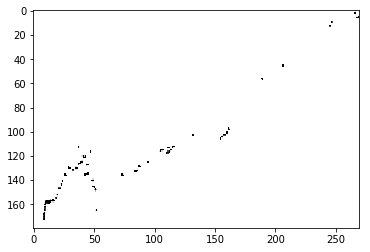

In [256]:
plt.imshow(img[1, :, :, 0],  cmap="gray")
plt.show()

In [257]:
model_config = {
    'inputs': dict(images=dict(shape=B('image_shape')),
                             labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cpna cpna cpna cpna', filters=[16, 32, 64, 128],
                 strides=2, pool_strides=2, kernel_size=3),
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'images',
    'loss': 'mse',
    
    'optimizer': ('Momentum', {'use_nesterov': True, 'learning_rate': 0.01, 'momentum': 0.5})}

In [258]:
# train_template = (Pipeline()
#                   .init_variable('loss_history', init_on_each_run=list)
#                   .init_model('dynamic', TFModel, 'image_model', config=model_config)
#                   .to_array()
#                   .train_model('image_model', fetches='loss',
#                                feed_dict={'images': B('images'),
#                                           'labels': B('target')}, 
#                                save_to=V('loss_history'), mode='a'))

# train_pipeline = (load_ppl + train_template) << train_set

# test_template = (Pipeline()
#                   .init_variable('loss', init_on_each_run=0)
#                   .init_variable('loss_history', init_on_each_run=list)
#                   .import_model('image_model', train_pipeline)
#                   .to_array()
#                   .train_model('image_model', fetches=['loss', 'predictions'],
#                                feed_dict={'images': B('images'),
#                                           'labels': B('target')}, 
#                                save_to=[V('loss'), B('predictions')], mode='w')
#                   .update_variable('loss_history', V('loss'), mode='a'))

In [259]:
train_template = (Pipeline()
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'image_model', config=model_config)
                  .to_array()
                  .train_model('image_model', fetches='TFModel/mean_squared_error/SquaredDifference:0',
                               feed_dict={'images': B('images'),
                                          'labels': B('target')}, 
                               save_to=V('loss_history'), mode='a')
                  .update_loss_history_dict())

train_pipeline = (load_ppl + train_template) << train_set

test_template = (Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .import_model('image_model', train_pipeline)
                  .to_array()
                  .train_model('image_model', fetches=['loss', 'predictions'],
                               feed_dict={'images': B('images'),
                                          'labels': B('target')}, 
                               save_to=[V('loss'), B('predictions')], mode='w')
                  .update_variable('loss_history', V('loss'), mode='a'))

In [260]:
test_pipeline = (load_ppl + test_template) << test_set

In [261]:
train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)
train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)









  0%|          | 0/195 [00:00<?, ?it/s]






  1%|          | 2/195 [00:01<02:04,  1.55it/s]

before ['rr_286' 'rr_266' 'rr_230' 'rr_379' 'rr_364' 'rr_193' 'rr_322' 'rr_222'
 'rr_217' 'rr_228' 'rr_256' 'rr_357' 'rr_298' 'rr_141' 'rr_350' 'rr_133'], after ['rr_322', 'rr_230', 'rr_222', 'rr_286', 'rr_379', 'rr_193', 'rr_266', 'rr_254', 'rr_364']


In [262]:
(train_pipeline.get_variable('loss_history_dict'))

{'rr_230': array([[ 1.1198589 ],
        [ 6.6461263 ],
        [12.382321  ],
        [11.165186  ],
        [ 0.19394444],
        [ 4.1692014 ],
        [ 1.1098679 ],
        [15.137536  ],
        [15.515944  ]], dtype=float32), 'rr_322': array([[3.7577052e+00],
        [4.6302481e+00],
        [3.5151083e+00],
        [1.7970303e+00],
        [7.2910577e-02],
        [4.6198019e-01],
        [8.2448912e+00],
        [3.0802155e-02],
        [9.5913863e-01],
        [9.8366652e+00],
        [1.3907053e+00],
        [8.8872337e-01],
        [7.3707223e-01],
        [7.9253620e-01],
        [1.6676658e-03],
        [2.3728285e+00]], dtype=float32)}

In [238]:
len(train_pipeline.get_variable('loss_history'))

2

In [151]:
train_pipeline.get_model_by_name('image_model').graph.get_tensor_by_name('TFModel/mean_squared_error/SquaredDifference:0')

<tf.Tensor 'TFModel/mean_squared_error/SquaredDifference:0' shape=(?, 1) dtype=float32>

In [60]:
# for i in tqdm(range(500)):
train_pipeline.run(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)
test_pipeline.run(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)


 99%|█████████▉| 194/195 [00:35<00:00,  5.47it/s]

 98%|█████████▊| 56/57 [00:09<00:00,  5.79it/s]


In [64]:
btch = test_pipeline.next_batch(len(test_set.indices), shuffle=True, n_epochs=None, drop_last=False, bar=True)



  0%|          | 0/9223372036854775807 [00:00<?, ?it/s]

In [66]:
metrics = np.abs(btch.predictions.reshape(-1) - btch.target.reshape(-1)) / btch.target.reshape(-1)
metrics = metrics.astype(np.float32)

In [67]:
np.mean(metrics)

1.211188

In [68]:
np.percentile(metrics, q=90)

1.6934712529182434

(array([42., 22.,  6.,  6.,  0.,  2.,  0.,  0.,  1.,  1.]),
 array([0.00222824, 0.17049473, 0.33876122, 0.50702771, 0.6752942 ,
        0.84356069, 1.01182717, 1.18009366, 1.34836015, 1.51662664,
        1.68489313]),
 <a list of 10 Patch objects>)

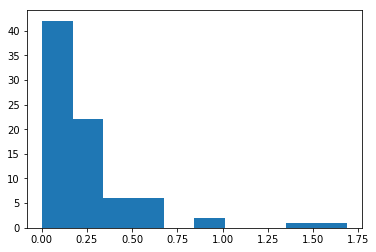

In [70]:
plt.hist(np.sort(metrics)[:-10])

(array([9., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 1.69254255,  7.80386004, 13.91517754, 20.02649503, 26.13781252,
        32.24913001, 38.3604475 , 44.47176499, 50.58308249, 56.69439998,
        62.80571747]),
 <a list of 10 Patch objects>)

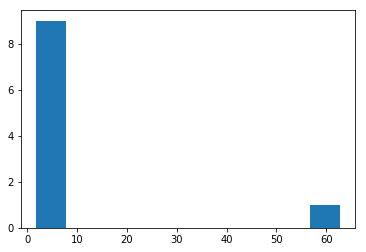

In [71]:
plt.hist(np.sort(metrics)[-10:])

In [84]:
ix = np.argsort(metrics)

Let's have a look at the worst predictions

target=[0.0029142], prediction=[0.18594268]


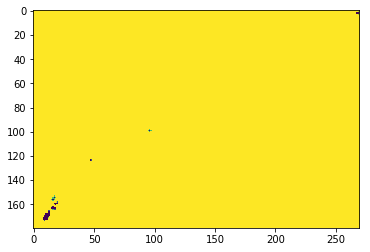

target=[0.02871019], prediction=[0.19995946]


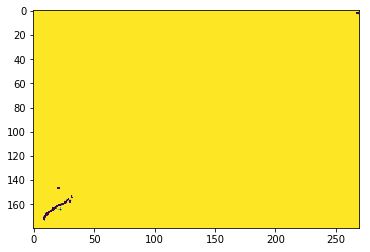

target=[0.0199481], prediction=[0.11976636]


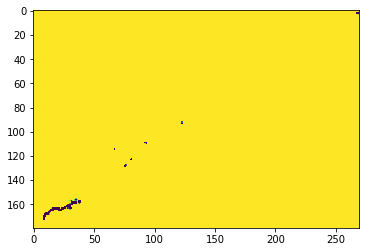

target=[0.01342052], prediction=[-0.03695702]


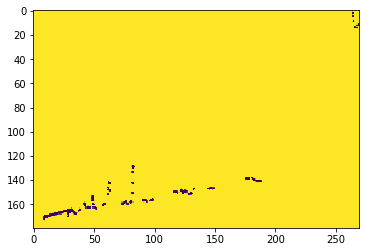

target=[0.04836037], prediction=[-0.09613595]


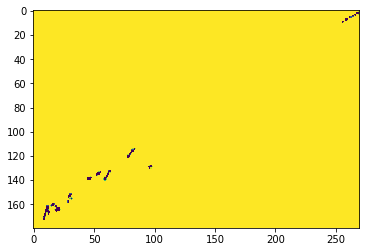

target=[0.03468613], prediction=[0.10359547]


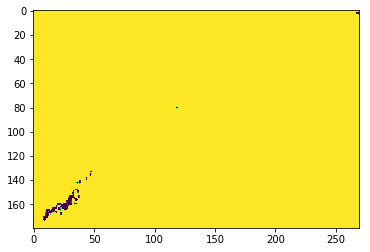

target=[0.0363825], prediction=[0.10751855]


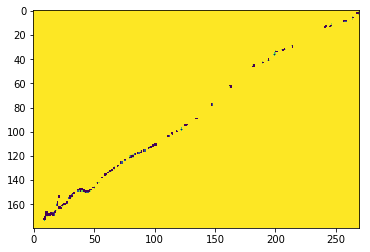

target=[0.04358268], prediction=[-0.03974568]


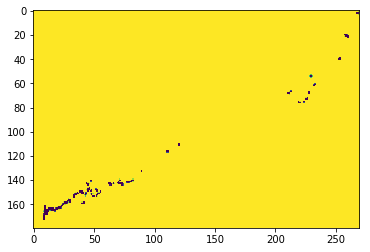

target=[0.00776829], prediction=[0.02098861]


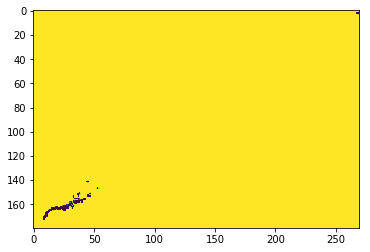

target=[0.05298849], prediction=[0.14267376]


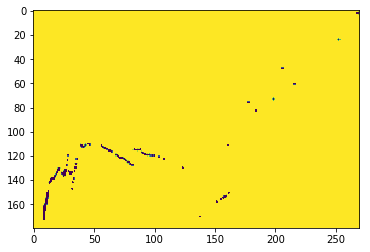

target=[0.0255464], prediction=[0.06858936]


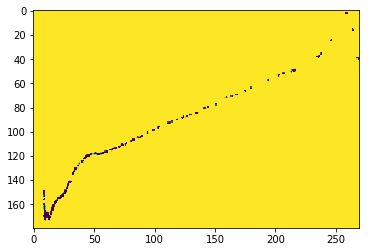

target=[0.06140565], prediction=[0.1481391]


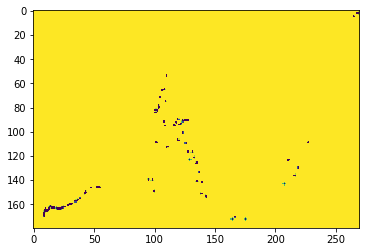

target=[0.05978367], prediction=[0.11400279]


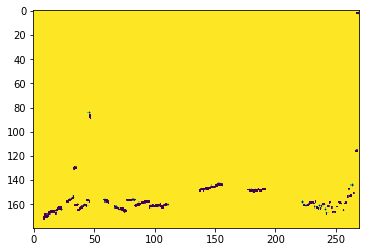

target=[0.04559509], prediction=[0.00705211]


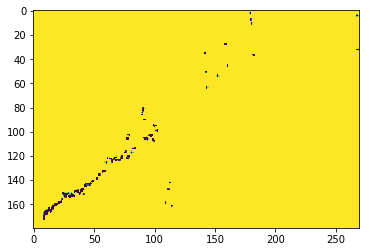

target=[0.1712788], prediction=[0.28139693]


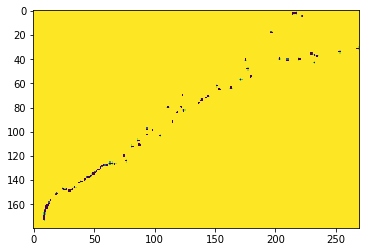

target=[0.09789339], prediction=[0.16061169]


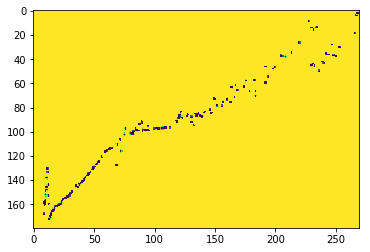

target=[0.19161868], prediction=[0.30408525]


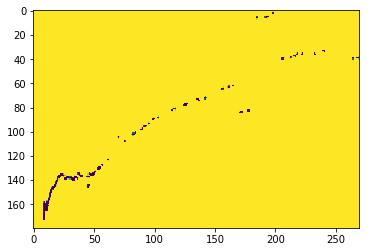

target=[0.08091825], prediction=[0.12662035]


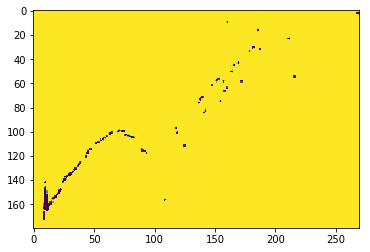

target=[0.15144314], prediction=[0.06863426]


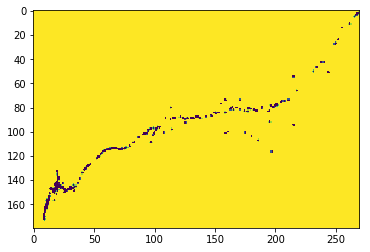

In [85]:
for i in range(1, 20):
    plt.imshow(btch.images[ix][-i, :, :, 0])
    print('target={}, prediction={}'.format(btch.target[ix][-i], btch.predictions[ix][-i]))
    plt.show()

# Train and test loss

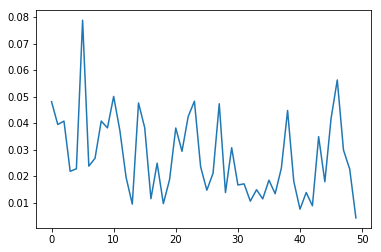

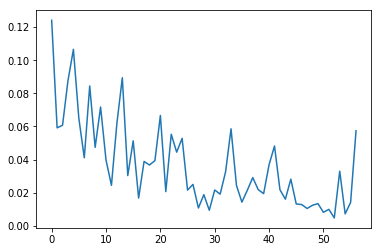

In [62]:
plt.plot(train_pipeline.get_variable('loss_history')[-50:])
plt.show()

plt.plot(test_pipeline.get_variable('loss_history'))
plt.show()

looks pretty much the same as the non-image models